# Descripcion del proyecto

Este proyecto trata de preveer el precio de la electricidad en la hora siguiente utilizando: 
* Valores pasados del precio de la electricidad
* Otras caracteristicas relacionadas con la generacion de energía y condiciones meteorológicas
    * Usaremos 2 datasets que contienen informacion acerca de la generacion de energia y meteorologica en España (2015 - 2019)
        * weather_features.csv: Contiene informacion acerca de las condiciones meteorologicas por cada hora
        * energy_dataset.csv: Contiene informacion acerca de la generacion de energia en España

**Toda esta informacion es con respecto a 5 grandes ciudades españolas (Sevilla, Madrid, Barcelona, Bilbao y Valencia)**
* *Hay que puntuar que 1/3 de la poblacion total española vive en estas 5 ciudades, por lo que asumimos que es mas que suficiente para llevar a cabo un  analisis exhaustivo* 

## VISUALIZAR DATOS PREDICHOS DE LA SERIE TEMPORAL

### Imports de librerias

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# Analisis exploratorio de los datos

In [2]:
# Leemos los datasets y comprobamos sus datos
df_energy = pd.read_csv("../DataSets/energy_dataset.csv", parse_dates = ["time"])
df_weather = pd.read_csv("../DataSets/weather_features.csv", parse_dates = ["dt_iso"])

In [3]:
df_energy.head(2)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.1,64.92


In [4]:
df_weather.head(2)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n


### Analisis Exploratorio y Limpieza del DataSet de Energia (df_energy)

* Eliminaremos todas las columnas con 0s y NaNs, ya que son inutiles.
* Tambien eliminaremos las columnas que no usaremos en nuestro analisis y que contienen previsiones para el dia siguiente de la carga total, energia solar y eolica.

In [5]:
# Ahora iremos mirando los datos, vemos que hay varios NaNs y 0s
df_energy.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.0,35046.00,35046.00,35045.00,35046.0,35046.0,35046.0,0.0,...,35045.00,35046.0,35046.00,35064.00,0.0,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,0.0,5622.74,4256.07,298.32,0.0,0.0,0.0,NaN,...,269.45,0.0,5464.48,1439.07,NaN,5471.22,28712.13,28696.94,49.87,57.88
std,85.35,354.57,0.0,2201.83,1961.60,52.52,0.0,0.0,0.0,NaN,...,50.20,0.0,3213.69,1677.70,NaN,3176.31,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,NaN,...,0.00,0.0,0.00,0.00,NaN,237.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,0.0,4126.00,2527.00,263.00,0.0,0.0,0.0,NaN,...,240.00,0.0,2933.00,69.00,NaN,2979.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,0.0,4969.00,4474.00,300.00,0.0,0.0,0.0,NaN,...,279.00,0.0,4849.00,576.00,NaN,4855.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,0.0,6429.00,5838.75,330.00,0.0,0.0,0.0,NaN,...,310.00,0.0,7398.00,2636.00,NaN,7353.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,0.0,20034.00,8359.00,449.00,0.0,0.0,0.0,NaN,...,357.00,0.0,17436.00,5836.00,NaN,17430.00,41390.00,41015.00,101.99,116.80


In [6]:
# Eliminamos las columnas que no usaremos
df_energy = df_energy.drop(["generation fossil coal-derived gas", "generation fossil oil shale", "generation fossil peat",
                            "generation geothermal", "generation hydro pumped storage aggregated", "generation marine", 
                            "generation wind offshore", "forecast wind offshore eday ahead", "total load forecast",
                            "forecast solar day ahead", "forecast wind onshore day ahead"], axis = 1)

In [7]:
df_energy.describe().round()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.0,35046.0,35046.0,35046.0,35045.0,35045.0,35045.0,35046.0,35047.0,35046.0,35046.0,35046.0,35045.0,35046.0,35028.0,35064.0,35064.0
mean,384.0,448.0,5623.0,4256.0,298.0,476.0,972.0,2605.0,6264.0,60.0,86.0,1433.0,269.0,5464.0,28697.0,50.0,58.0
std,85.0,355.0,2202.0,1962.0,53.0,792.0,401.0,1835.0,840.0,20.0,14.0,1680.0,50.0,3214.0,4575.0,15.0,14.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18041.0,2.0,9.0
25%,333.0,0.0,4126.0,2527.0,263.0,0.0,637.0,1077.0,5760.0,53.0,73.0,71.0,240.0,2933.0,24808.0,41.0,49.0
50%,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,28901.0,51.0,58.0
75%,433.0,757.0,6429.0,5839.0,330.0,616.0,1250.0,3757.0,7025.0,80.0,97.0,2578.0,310.0,7398.0,32192.0,61.0,68.0
max,592.0,999.0,20034.0,8359.0,449.0,4523.0,2000.0,9728.0,7117.0,106.0,119.0,5792.0,357.0,17436.0,41015.0,102.0,117.0


In [8]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [9]:
df_energy.shape

(35064, 18)

In [10]:
# Observamos que la columna "time" (que tambien queremos que funcione como index) no ha sido parseada correctamente y es 
# reconocida como si fuera un objeto de tipo no nulo (35064 non-null  object)
# Por lo que lo parsearemos y lo convertiremos en indice
df_energy["time"] = pd.to_datetime(df_energy["time"], utc = True, infer_datetime_format = True)
df_energy = df_energy.set_index("time")
df_energy.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.1,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.1,64.92


In [11]:
# Ahora buscaremos los NaNs que previamente observamos tener, y los datos duplicados
print("Hay {} NaNs o valores que faltan en df_energy.".format(df_energy.isnull().values.sum()))

temporary_energy = df_energy.duplicated(keep = "first").sum()

print("Hay {} filas duplicadas en df_energy basado en todas las columnas.".format(temporary_energy))
# Podemos observar que el DataSet de energia tiene datos con valores NaN por lo que debemos seguir investigando.
# Dado que se trata de una tarea de previsión de series temporales, no podemos limitarnos a 
    # eliminar las filas con los valores que faltan y sería mejor rellenar los valores que faltan mediante interpolación.

Hay 292 NaNs o valores que faltan en df_energy.
Hay 0 filas duplicadas en df_energy basado en todas las columnas.


In [12]:
# Por lo que buscaremos el numero de NaNs para cada columna
df_energy.isnull().sum(axis = 0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Text(0.5, 1.0, 'Actual Total Load (Primeras 2 semanas)')

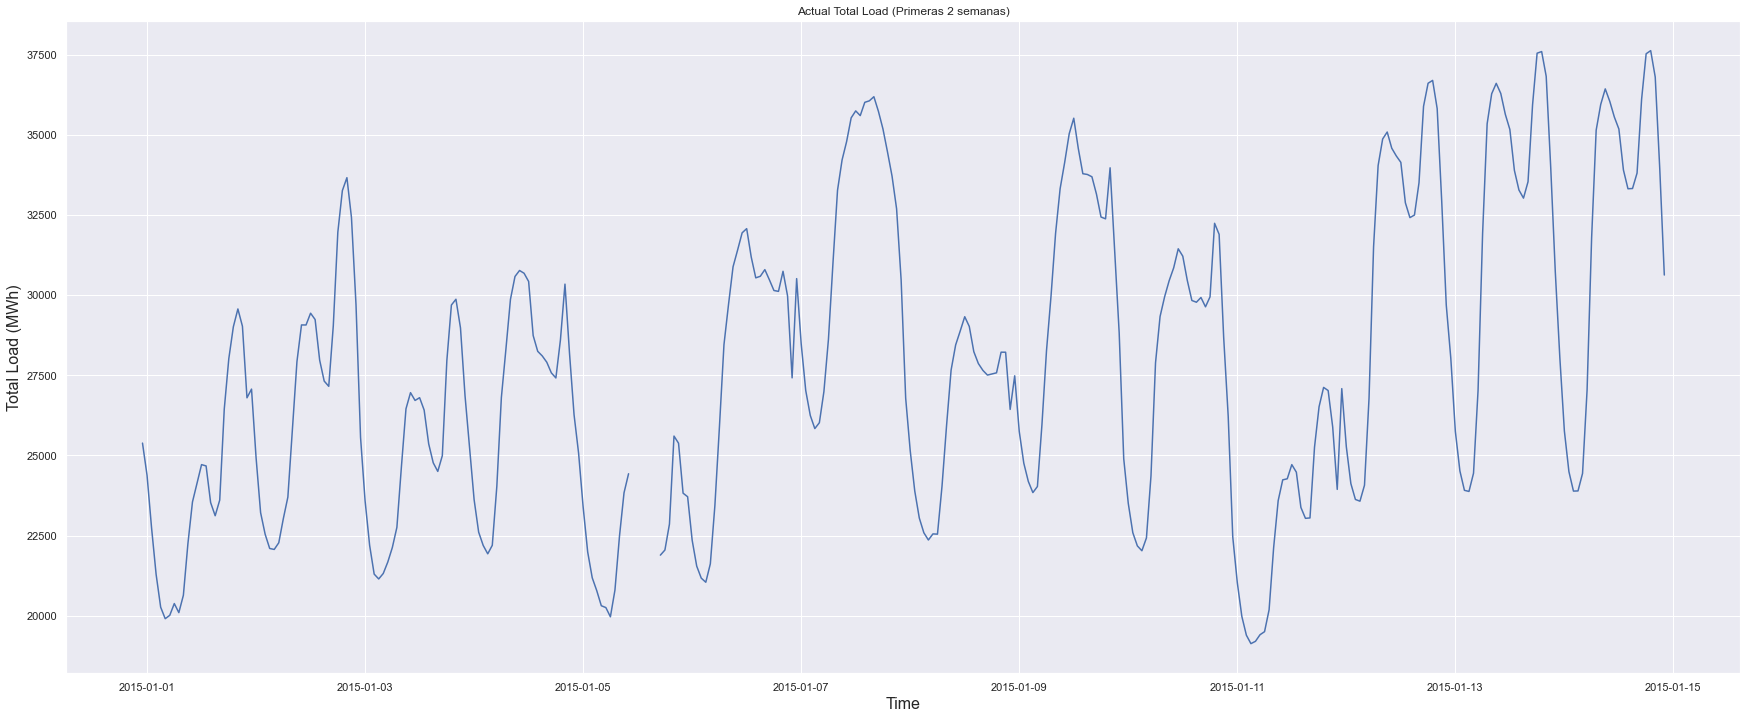

In [13]:
# La gran mayoria de los valores nulos se encuentran en la columna "total load actual" (36). Por lo que la visualizaremos
# para ver que podemos hacer. Tambien observamos que la columna "price actual" no tiene valores nulos - 
    # Esto es bueno ya que es la variable que utilizaremos para entrenar el modelo. 
# El numero de valores nulos tan parecido en las variables que tienen que ver con el tipo de generacion de energia
# nos indican que probablemente aparezcan en las mismas filas .
    # Visualizaremos la columna "total load actual" -- Para las 2 primeras semanas
sns.set()
fig, ax = plt.subplots(figsize = (30, 12))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Total Load (MWh)", fontsize = 16)
ax.plot(df_energy["total load actual"][0:336])  # end = 336(cada unidad es una Hora) - las 2 primeras semanas (24 * 7 * 2)
ax.set_title("Actual Total Load (Primeras 2 semanas)")
# plt.show()

In [14]:
# Al hacer el Zoom, observamos que hay valores nulos para algunas horas, el numero de valores que faltan y su comportamiento 
# nos indican que una interpolacion rellenaría los NaNs bastante bien. Seguiremos investigando si los valores nulos
# coinciden en las distintas columnas. Visualizaremos las 10 ultimas filas que tengan un NaN en cualquier celda
df_energy[df_energy.isnull().any(axis = 1)].tail(10)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2016-06-11 23:00:00+00:00,356.0,595.0,5719.0,6165.0,274.0,382.0,NaN,1325.0,5056.0,56.0,86.0,30.0,291.0,2019.0,24155.0,60.23,48.72
2016-07-09 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6923.0,NaN,NaN,NaN,NaN,NaN,NaN,45.72,51.72
2016-07-11 22:00:00+00:00,346.0,595.0,5951.0,6131.0,NaN,494.0,709.0,1215.0,5058.0,49.0,83.0,31.0,309.0,2031.0,25103.0,64.99,47.49
2016-09-28 07:00:00+00:00,347.0,594.0,5522.0,6272.0,292.0,0.0,524.0,2494.0,6997.0,61.0,86.0,982.0,300.0,5478.0,NaN,49.72,56.40
2016-10-27 21:00:00+00:00,351.0,554.0,7176.0,5690.0,321.0,NaN,417.0,1295.0,6967.0,58.0,91.0,70.0,299.0,3193.0,26583.0,55.70,62.84
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,NaN,69.87,64.93


In [15]:
# Si hicieramos una busqueda manual, todo apunta a que confirmariamos la idea de que los valores nulos que respectan
# al tipo de generacion de energia coinciden en su mayoria. Los valores nulos en "total load actual" tambien coinciden
# con las columnas mencionadas, pero tambien aparecen en otras filas. Para manejar esto usaremos la interpolacion lineal
# con direccion hacia adelante. Quiza otro tipo de interpolacion seria mejor.
    # Habra una pequeña parte de nuestros datos que seran ruidosos pero no afectara significativamente.
df_energy.interpolate(method = "linear", limit_direction = "forward", inplace = True, axis = 0)

# METER ALGUNA GRAFICA MAS DE LAS DE ANTES

Text(0.5, 1.0, 'Actual Total Load (Primeras 2 semanas)')

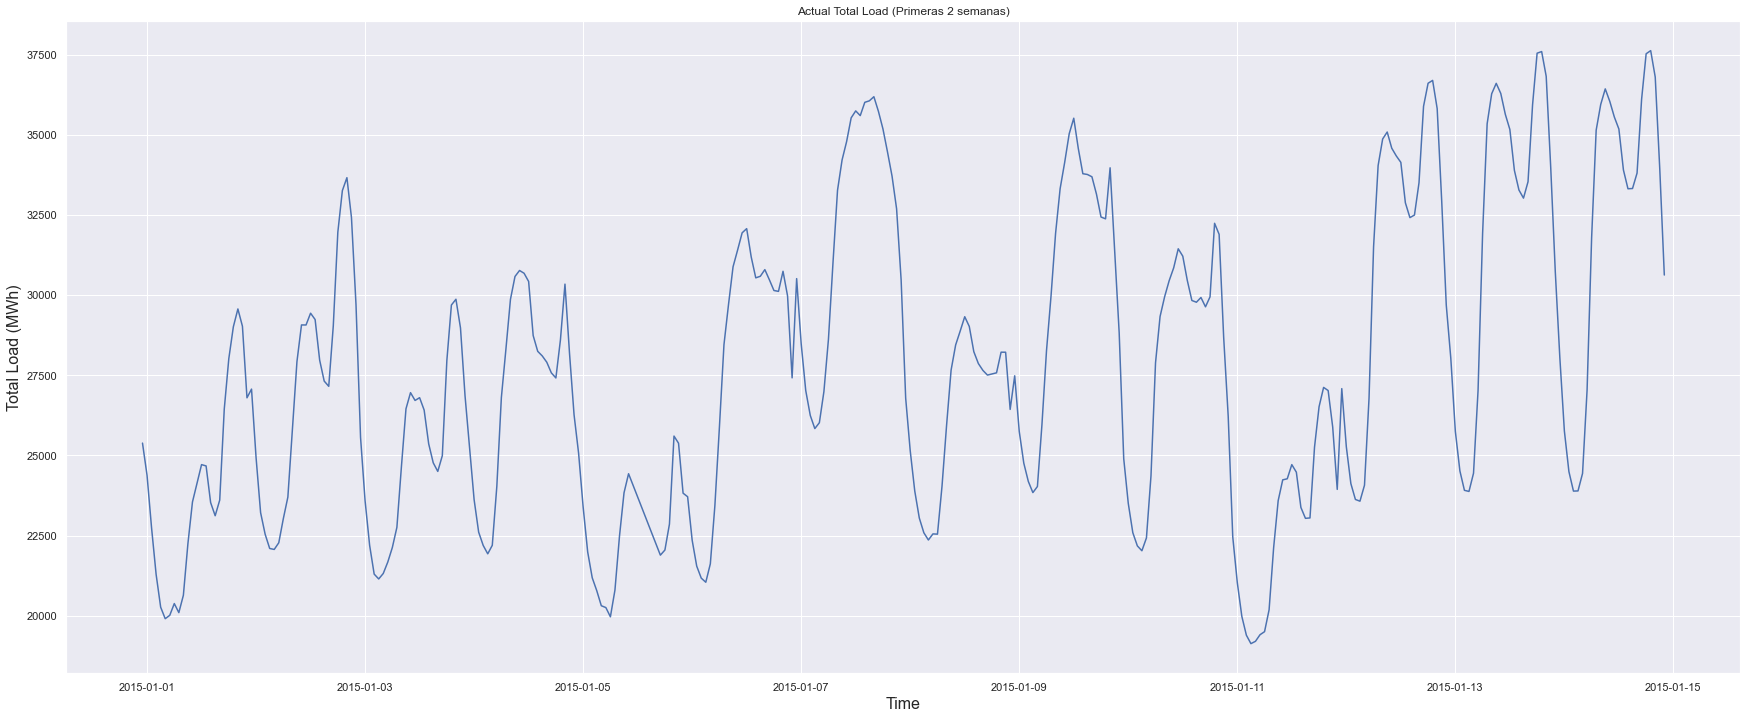

In [16]:
sns.set()
fig, ax = plt.subplots(figsize = (30, 12))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Total Load (MWh)", fontsize = 16)
ax.plot(df_energy["total load actual"][0:336])  # end = 336(cada unidad es una Hora) - las 2 primeras semanas (24 * 7 * 2)
ax.set_title("Actual Total Load (Primeras 2 semanas)")

In [17]:
# Visualizaremos el numero de valores que no sean cero para cada columna
print("Valores distintos de 0 para cada columna:\n", df_energy.astype(bool).sum(axis = 0), sep = "\n")

Valores distintos de 0 para cada columna:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


In [18]:
df_energy.notnull().sum(axis=0)
# Al comparar los valores que no son nulos (sabiendo que no hay ningun valor nulo al haber hecho la interpolacion)
    # con los valores que no son zero, sabemos cuantos 0s tendra cada columna, pero no debe preocuparnos los 0s que haya 
    # con respecto a las variables de tipo de generacion de energia

generation biomass                             35064
generation fossil brown coal/lignite           35064
generation fossil gas                          35064
generation fossil hard coal                    35064
generation fossil oil                          35064
generation hydro pumped storage consumption    35064
generation hydro run-of-river and poundage     35064
generation hydro water reservoir               35064
generation nuclear                             35064
generation other                               35064
generation other renewable                     35064
generation solar                               35064
generation waste                               35064
generation wind onshore                        35064
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64

**Parece que ya tenemos el DataSet de energia limpio y listo para trabajar. Hay algun cero todavia pero no debe preocuparnos.** 
* La "generacion hydro pumped storage consumption" puede parecer sospechoso, pero tenemos que tener en cuenta que este tipo de energia solo se utiliza para equilibrar la carga, consumiendose cuando hay picos de demanda energética.

### Analisis exploratorio y limpieza del DataSet de tiempo (df_weather)

In [19]:
df_weather.head(5)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [20]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


In [21]:
df_weather.shape

(178396, 17)

In [22]:
# Observamos que todas las columnas tienen el mismo numero de filas, pero habra que comprobar cada ciudad particularmente
# Puntuamos que las temperaturas estan en grados Kelvin - Tambien podemos observar algunos errores:
    # 1. De primeras hay por lo menos un Outlier en la columna de Presion ("pressure") ya que el valor maximo (1008371.00 hPa
        # aproximadamente 100 MPa - MegaPascales), es excesivamente grande para ser cierto (986 atmosferas)
    # 2. Hay por lo menos otro Outlier en la columna de velocidad del viento ("wind_speed"), aparte de que se ve en la gran
        # diferencia entre la media y el valor maximo, 133 m/s es la velocidad de un Tornado de nivel F5 (la intensidad maxima)
    # 3. La columna de precipitaciones en 3 horas ("rain_3h") mide los milimetros (mm) de agua en 3h, por lo que
        # obviamente deberia tener mas milimetros de agua que la columna de "rain_1h", pero no es asi, habra que investigarlo
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [23]:
# Tendremos que cambiar los tipos de algunas variables para que todas sean floats y parsear la variable "dt_iso" a la vez que 
    # le cambiaremos el nombre para que coincida con el indice del DataSet de energia, y por supuesto indexarlo tambien
cols = df_weather.select_dtypes(include = [np.int64]).columns
for col in cols:
    df_weather[col] = df_weather[col].values.astype(np.float64)

df_weather["time"] = pd.to_datetime(df_weather["dt_iso"], utc = True, infer_datetime_format = True)
df_weather = df_weather.drop(["dt_iso"], axis = 1)
df_weather = df_weather.set_index("time")
df_weather.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


In [24]:
# Dividiremos el DataSet en 5 datasets, uno para cada ciudad, antes exploraremos un poco los datos
df_weather.groupby("city_name").mean()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [25]:
print("Hay {} valores que faltan o NaNs en df_weather.".format(df_weather.isnull().values.sum()))

temporary_weather = df_weather.duplicated(keep = "first").sum()

print("Hay {} filas duplicadas en df_weather basados en todas las columnas.".format(temporary_weather))

Hay 0 valores que faltan o NaNs en df_weather.
Hay 8622 filas duplicadas en df_weather basados en todas las columnas.


In [26]:
# El metodo usado previamente, nos dice cuantas filas tienen exactamente el mismo valor, pero esto no es lo que buscamos,
# Nosotros queremos saber que no haya valores duplicados para la misma hora en la misma ciudad
print("Hay {} observaciones en df_energy.".format(df_energy.shape[0]))

cities = df_weather["city_name"].unique()
grouped_weather = df_weather.groupby("city_name")

for city in cities:
    print("Hay {} observaciones en df_weather".format(grouped_weather.get_group("{}".format(city)).shape[0]), 
          "en la ciudad: {}.".format(city))

Hay 35064 observaciones en df_energy.
Hay 35145 observaciones en df_weather en la ciudad: Valencia.
Hay 36267 observaciones en df_weather en la ciudad: Madrid.
Hay 35951 observaciones en df_weather en la ciudad: Bilbao.
Hay 35476 observaciones en df_weather en la ciudad:  Barcelona.
Hay 35557 observaciones en df_weather en la ciudad: Seville.


In [27]:
# Todavia no podemos unir los datasets ya que hay mas valores en el df_weather para cada ciudad que en el df_energy.
# Nos quedaremos con las primeras filas que tengan el mismo valor de tiempo y nombre de ciudad
df_weather_new = df_weather.reset_index().drop_duplicates(subset = ["time", "city_name"],
                                                      keep = "first").set_index("time")

In [28]:
print("Hay {} observaciones en df_energy.".format(df_energy.shape[0]))

grouped_weather = df_weather_new.groupby("city_name")

for city in cities:
    print("Hay {} observaciones en df_weather"
          .format(grouped_weather.get_group("{}".format(city)).shape[0]), 
          "en la ciudad: {}.".format(city))

Hay 35064 observaciones en df_energy.
Hay 35064 observaciones en df_weather en la ciudad: Valencia.
Hay 35064 observaciones en df_weather en la ciudad: Madrid.
Hay 35064 observaciones en df_weather en la ciudad: Bilbao.
Hay 35064 observaciones en df_weather en la ciudad:  Barcelona.
Hay 35064 observaciones en df_weather en la ciudad: Seville.


In [29]:
# Como podemos ver ya coinciden el numero de filas. Ahora comprobaremos que todas las variables tienen sentido en la prediccion
# Para ello nos crearemos otro dataset que se quede con las ultimas en vez de con las primeras (filas duplicadas)
df_weather2 = df_weather.reset_index().drop_duplicates(subset=["time", "city_name"],
                                                      keep="last").set_index("time")
# Y luego definiremos una función que nos da el valor de R2 (R al cuadrado) para una columna en 2 datasets distintos para 
    # comprobar la consistencia de la informacion de cada columna
def consistencia_R2(df_1, df_2, column, categorical = False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("Puntuacion de R cuadrado de {} es {}".format(column, r2.round(3)))

In [30]:
# Comprobaremos la consistencia de los valores cualitativos del dataset, y podemos comprobar que hay incosistencias.
consistencia_R2(df_weather_new, df_weather2, "weather_description", categorical = True)
consistencia_R2(df_weather_new, df_weather2, "weather_main", categorical = True)
consistencia_R2(df_weather_new, df_weather2, "weather_icon", categorical = True)
consistencia_R2(df_weather_new, df_weather2, "weather_id")

Puntuacion de R cuadrado de weather_description es 0.973
Puntuacion de R cuadrado de weather_main es 0.963
Puntuacion de R cuadrado de weather_icon es 0.985
Puntuacion de R cuadrado de weather_id es 0.921


In [31]:
# Y ahora comprobaremos la consistencia de los valores cuantitativos del dataset
columns_df_weather = df_weather_new.columns.drop(["city_name", "weather_description", "weather_main", 
                                                 "weather_id", "weather_icon"])

for col in columns_df_weather:
    consistencia_R2(df_weather_new, df_weather2, col)
# Podemos comprobar que estamos acertados al pensar que las variables cualitativas son las razones para tener valores duplicados
# Y aunque no estamos del todo seguros, ya que la forma elegida para comprobar la consitencia no es completamente acertada
    # ya que compara 2 dataframes cuyos duplicados han sido limpiados solo de dos maneras 
        # (guardar las primeras, y guardar las ultimas filas)

Puntuacion de R cuadrado de temp es 1.0
Puntuacion de R cuadrado de temp_min es 1.0
Puntuacion de R cuadrado de temp_max es 1.0
Puntuacion de R cuadrado de pressure es 1.0
Puntuacion de R cuadrado de humidity es 1.0
Puntuacion de R cuadrado de wind_speed es 1.0
Puntuacion de R cuadrado de wind_deg es 1.0
Puntuacion de R cuadrado de rain_1h es 1.0
Puntuacion de R cuadrado de rain_3h es 1.0
Puntuacion de R cuadrado de snow_3h es 1.0
Puntuacion de R cuadrado de clouds_all es 1.0


In [32]:
# Ahora podremos eliminar las variables cualitativas para terminar de limpiar el dataset y solo nos quedara tratar los outliers
    # de los cuales hablamos al comenzar el analisis exploratorio del df_weather
df_weather = df_weather_new
df_weather = df_weather.drop(["weather_main", "weather_id", 
                              "weather_description", "weather_icon"], axis = 1)

temp_weather = df_weather.reset_index().duplicated(subset = ["time", "city_name"], 
                                                   keep = "first").sum()
print("Hay {} filas duplicadas en df_weather" \
      "basados en todas las columnas excepto 'time' y 'city_name'.".format(temp_weather))

Hay 0 filas duplicadas en df_weatherbasados en todas las columnas excepto 'time' y 'city_name'.


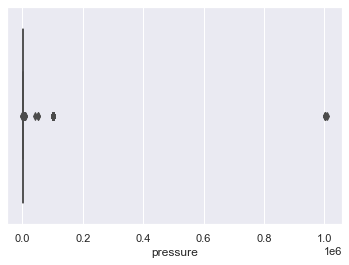

In [33]:
# Comprobamos los outliers para la Presion:
sns.boxplot(x = df_weather["pressure"])
plt.show()

In [34]:
# Sabemos que en la Peninsula Ibérica no se ha registrado una presion mayor de 1051 hPa, ni menos de 931 hPa
    # Asique reemplazaremos los valores de presion que se salgan de este rango con NaNs
df_weather.loc[df_weather.pressure > 1051, "pressure"] = np.nan
df_weather.loc[df_weather.pressure < 931, "pressure"] = np.nan

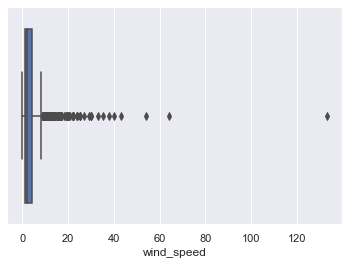

In [35]:
# Comprobaremos los outliers de la variable velocidad del viento
sns.boxplot(x = df_weather["wind_speed"])
plt.show()

In [36]:
# De la misma forma, estableceremos como NaN cualquier registro que supere los 50 m/s que es la velocidad mas alta registrada
df_weather.loc[df_weather.wind_speed > 50, "wind_speed"] = np.nan

In [37]:
# Mediante interpolacion lineal hacia adelante, Rellenaremos los valores nulos
df_weather.interpolate(method = "linear", limit_direction="forward", inplace = True, axis = 0)

In [38]:
# El ultimo punto que nos quedaba comprobar eran los campos "rain_1h" y "rain_3h", intuiamos que en "rain_3h" reside el problema
# Ya podremos dividir el Dataset en 5, uno para cada ciudad
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby("city_name")]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [39]:
# Finalmente unimos los datasets en un dataset final
df_final = df_energy

for df in dfs:
    city = df["city_name"].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix("_{}".format(city_str))
    df_final = df_final.merge(df, on=["time"], how = "outer")
    df_final = df_final.drop("city_name_{}".format(city_str), axis = 1)

Text(0.5, 1.0, 'Lluvia para las ultimas 3 horas en Bilbao')

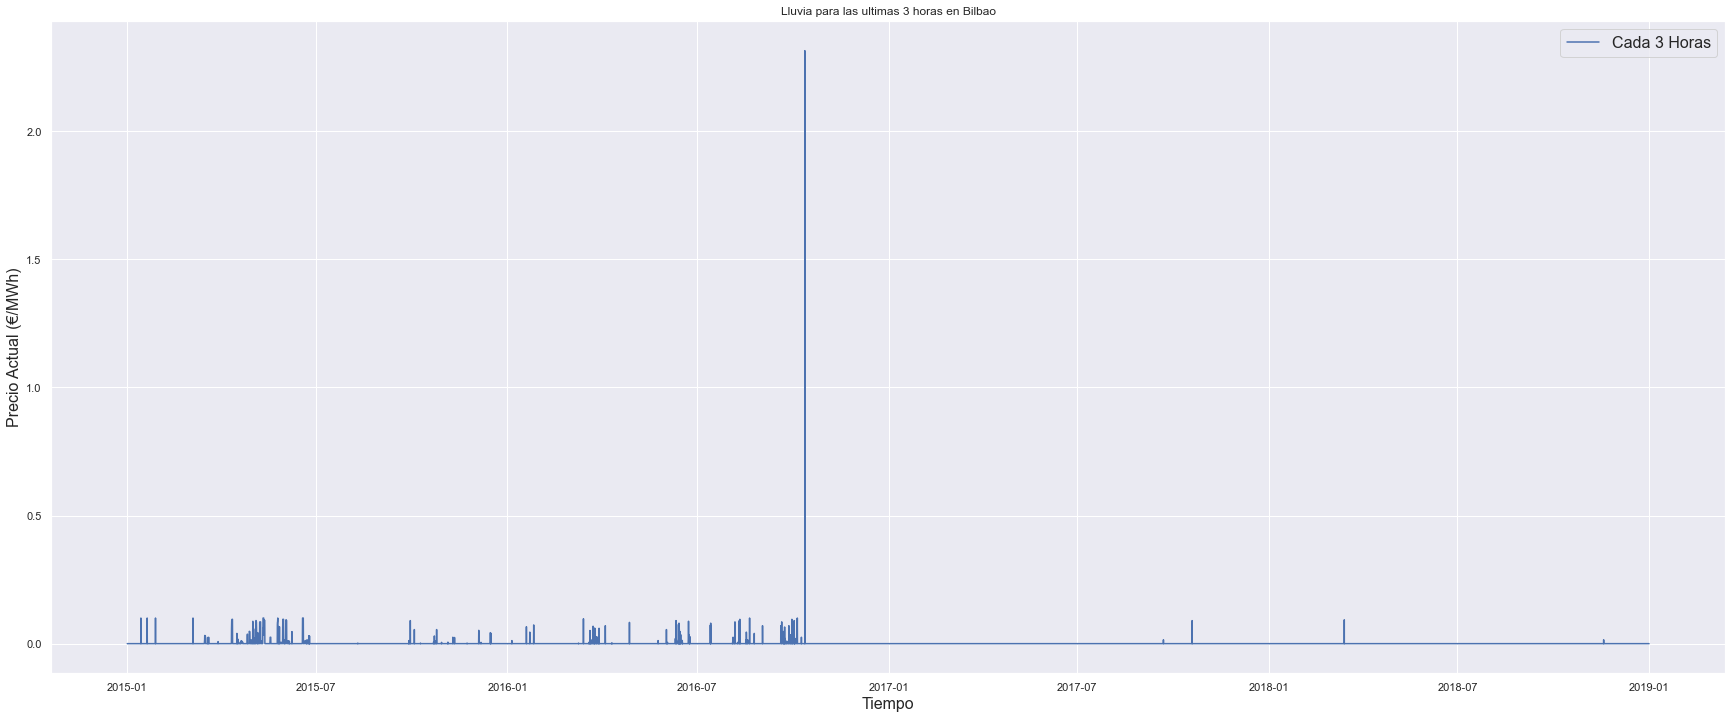

In [40]:
sns.set()
fig, ax = plt.subplots(figsize = (30, 12))
ax.set_xlabel("Tiempo", fontsize = 16)
ax.plot(df_final["rain_3h_Bilbao"], label = "Cada 3 Horas")
ax.set_ylabel("Precio Actual (€/MWh)", fontsize = 16)
ax.legend(fontsize = 16)
ax.set_title("Lluvia para las ultimas 3 horas en Bilbao")
# En esta grafica observamos que esta variable no es para nada fiable, por lo que lo eliminaremos del dataset

In [41]:
# Eliminamos dichas columnas del DataSet final
ciudades = ["Bilbao", "Barcelona", "Madrid", "Seville", "Valencia"]

for ciudad in ciudades:
    df_final = df_final.drop(["rain_3h_{}".format(ciudad)], axis = 1)

In [42]:
# Mediante la correlacion de Pearson, comprobaremos la correlacion que hay entre el precio actual y el resto de variables
correlations = df_final.corr(method = "pearson")
print(correlations["price actual"].sort_values(ascending = False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

In [43]:
# Observamos que hay varias correlaciones muy interesantes, de primeras observamos que todas las variables que respectan
# a la velocidad del viente se correlacionan negativamente, mientras que la generacion de energia procedente de fosiles
# y la temperatura se correlacionan de forma positiva con el precio actual. 
# Datos muy llamativos son "snow_3h_Barcelona" y "snow_3h_Seville" que da valores invalidos en la correlacion con el precio. 
    # Eliminaremos dichas columnas 
df_final = df_final.drop(["snow_3h_Barcelona", "snow_3h_Seville"], axis = 1)

# Podemos utilizar un coeficiente de correlacion de Spearmen, (No Lineal)

In [44]:
df_final.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0


### Generacion de las caracteristicas principales

In [45]:
# Ahora voy a generar varias caracteristicas en el DataSet, que he considerado relevantes:
    # Hora, Dia de la semana y Mes
    # Estableceremos las horas de trabajo, quitando el descanso para comer (muy comun en España)
    # Estableceremos el rango de temperaturas, restando a la maxima posible, la minima
ciudades = ["Barcelona", "Bilbao", "Madrid", "Seville", "Valencia"]

# Generamos Hora, Dia y mes y las asignamos al DataSet
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, "hour"] = hour
    df_final.loc[position, "weekday"] = weekday
    df_final.loc[position, "month"] = month
    
    # Establecemos las horas de trabajo siendo 2 si es hora de trabajo, 1 el descanso para comer y 0 cualquier otra hora
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, "business hour"] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, "business hour"] = 1
    else:
        df_final.loc[position, "business hour"] = 0
    
    # Ahora estableceremos la posibilidad de que sea fin de semana, siendo 2 si es Domingo y 1 si es Sábado
    if (weekday == 6):
        df_final.loc[position, "weekday"] = 2
    elif (weekday == 5):
        df_final.loc[position, "weekday"] = 1
    else:
        df_final.loc[position, "weekday"] = 0
    
    # Al comprobar que las temperaturas guardan una correlacion positiva, estableceremos el rango de temperaturas
    # para disponer de informacion extra mas detallada
    for ciudad in ciudades:
        temp_max = df_final.loc[position, "temp_max_{}".format(ciudad)]
        temp_min = df_final.loc[position, "temp_min_{}".format(ciudad)]
        df_final.loc[position, "temp_range_{}".format(ciudad)] = abs(temp_max - temp_min)
        
# Ahora generare una ponderacion de las temperaturas en base a la poblacion de cada ciudad registradas en 2018 
total_pobl = 6155116 + 5179243 + 1645342 + 1305342 + 987000
peso_Madrid = 6155116 / total_pobl
peso_Barcelona = 5179243 / total_pobl
peso_Valencia = 1645342 / total_pobl
peso_Seville = 1305342 / total_pobl
peso_Bilbao = 987000 / total_pobl
peso_ciudades = {"Madrid": peso_Madrid, 
                  "Barcelona": peso_Barcelona,
                  "Valencia": peso_Valencia,
                  "Seville": peso_Seville,
                  "Bilbao": peso_Bilbao}

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for ciudad in ciudades:
        temp = df_final.loc[position, "temp_{}".format(ciudad)]
        temp_weighted += temp * peso_ciudades.get("{}".format(ciudad))
    df_final.loc[position, "temp_weighted"] = temp_weighted

# Generaré una carácteristica que une las 2 fuentes de energia relacionadas con el carbón y que estan altamente correlacionadas
df_final["generation coal all"] = df_final["generation fossil hard coal"] + df_final["generation fossil brown coal/lignite"]

# Visualizamos la cola ya que en los primeros datos la temp_min y la temp_max es igual, por lo que no se aprecia el rango
df_final.tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,weekday,month,business hour,temp_range_Barcelona,temp_range_Bilbao,temp_range_Madrid,temp_range_Seville,temp_range_Valencia,temp_weighted,generation coal all
time,,,,,,,,,,,,,,,,,,,,,
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0.0,12.0,2.0,4.0,2.0,3.0,1.0,1.0,284.187736,2628.0
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0.0,12.0,2.0,3.0,3.0,3.0,1.0,2.0,281.762006,2566.0
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0.0,12.0,2.0,4.0,0.0,0.0,0.0,1.0,280.414970,2422.0
2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,...,0.0,12.0,0.0,6.0,1.0,1.0,0.0,2.0,279.150881,2293.0
2018-12-31 22:00:00+00:00,290.0,0.0,6926.0,2166.0,163.0,108.0,1069.0,1686.0,6075.0,61.0,...,0.0,12.0,0.0,6.0,1.0,0.0,3.0,2.0,278.051695,2166.0


### Seleccion de Características

In [46]:
# Primero vamos a definir una funcion para los datos multivariables
def datos_multivariables(dataset, target, start_index, end_index, history_size,
                         target_size, step, single_step = False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [47]:
# Ahora definimos el limite de los datos de entrenamiento, validacion y test
train_limit = 27048
val_limit = 31056
test_limit = 35064

# Definimos los datos del Target (y, que son los valores del precio); y los valores de X (datos del DataSet sin el precio)
y = df_final["price actual"].values 
X = df_final[df_final.columns.drop("price actual")].values

y = y.reshape(-1, 1)

# Definimos los escaladores para luego entrenarlos
# Variables estandarizadas para que los que tengan menos influencia no estropeen el modelo, escalar los datos de 0 a 1
escalador_X = MinMaxScaler(feature_range = (0, 1))
escalador_y = MinMaxScaler(feature_range = (0, 1))

# Los entrenamos
escalador_X.fit(X[:train_limit])
escalador_y.fit(y[:train_limit])

MinMaxScaler()

In [48]:
# Transformamos los escaladores
X_norm = escalador_X.transform(X)
y_norm = escalador_y.transform(y)

# Creamos un PCA eliminando los que tienen una correlacion superior al 80% y los ajustamos para los datos de entrenamiento
pca = PCA(n_components = 0.8)
X_pca = pca.fit(X_norm[:train_limit])
X_pca = pca.transform(X_norm)
# PCA para reducir la dimension en la que trabajamos - buscamos eliminar variables ruidosas (sin informacion)
# Componentes principales y no lineales
# Imagina comparar distancia interplanetaria y distancia entre ciudades.

# Comprobamos cuantas filas tiene para comprobar que todo esta correcto (debe tener 35064, y asi es)
X_pca.shape
# Al hacer comp. principales, econtramos variables, la primera mas variabilidad que las siguientes.

(35064, 16)

In [49]:
# Establecemos que cada chunk sea de 24 y cual sera el siguiente Target
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)
chunks = 24 # 24 variables, las mas relevantes, desde la que mas variabilidad tiene hasta la que capta menos.
next_target = 0

# Aplicamos la funcion de datos multivariables
X_train, y_train = datos_multivariables(dataset_norm, dataset_norm[:, -1], 0, train_limit, chunks, 
                                        next_target, step=1, single_step = True)

X_val, y_val = datos_multivariables(dataset_norm, dataset_norm[:, -1],
                                    train_limit, val_limit, chunks, 
                                    next_target, step=1, single_step = True)

X_test, y_test = datos_multivariables(dataset_norm, dataset_norm[:, -1],
                                      val_limit, test_limit, chunks, 
                                      next_target, step=1, single_step = True)

# Definimos el tamaño del lote y del buffer
batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [50]:
# Definiremos algunos parametros comunes para los modelos
    # Definiremos la perdida (error) y la metrica para que ajustar dicho error
    # Tambien definiremos la tasa de aprendizaje y le pondremos un tope de 10 iteracciones si deja de aprender
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

learning_rate = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-4 * 10**(epoch / 10))

epoch_stop = tf.keras.callbacks.EarlyStopping(patience = 10)

# Aqui definimos los datos de test en forma de columna y su inversa
y_test = y_test.reshape(-1, 1)
y_test_inv = escalador_y.inverse_transform(y_test)

## Funciones

### Funcion necesaria para representar el modelo

In [51]:
def plot_rmse_with_losses(history):
    
    # Evaluamos la precision y el error de los datos de entrenamiento y validacion
    # RMSE - al ser cuadratico, elevamos el error al cuadrado por lo que sale mas grande - mas importancia a los errores grandes
    
    train_rmse = history.history["root_mean_squared_error"]
    val_rmse = history.history["val_root_mean_squared_error"]
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Visualizamos iteracciones vs la precision y el error de los datos de entrenamiento y validacion
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label="Training RMSE")
    plt.plot(val_rmse, label="Validation RMSE")
    plt.legend()
    plt.title("Epochs vs. Training and Validation RMSE")
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Epochs vs. Training and Validation Loss")
    
    plt.show()

### Función para definir el modelo

In [52]:
def establecer_check_opt_model(check, opt, model, iteracciones):
    model_checkp = tf.keras.callbacks.ModelCheckpoint(check, save_best_only = True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = opt, amsgrad = True)
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metric)
    
    history = model.fit(train, epochs = iteracciones, validation_data = validation,
                        callbacks = [epoch_stop, model_checkp])
    
    return history

### Funciones para utilizar la metrica U2 de Theil

In [53]:
def division(measure, previous):
    return measure / previous

def power(measure):
    return np.power(measure, 2)

def summ(measure):
    return np.sum(measure)

def mean(N, measure):
    return (1/N) * measure

def sqrt(measure):
    return np.sqrt(measure)

def U2Theil(y, y_forecast):
    N = len(y)
    
    s_numerator = y_forecast[1:] - y[1:]
    div_numerator = division(s_numerator, y[:-1])
    power_numerator = power(div_numerator)
    sum_numerator = summ(power_numerator)
    mean_numerator = mean(N, sum_numerator)
    num = sqrt(mean_numerator)
    
    s_denominator = y[1:] - y[:-1]
    power_denominator = power(division(s_denominator, y[:-1]))
    denom = sqrt(mean(N, summ(power_denominator)))
        
    theilU2 = num / denom
    
    return theilU2

### Función para generar las predicciones y visualizar las metricas ( RMSE, MAE y U2 )

In [54]:
def forecasts_metrics(check):
    model = tf.keras.models.load_model(check)

    forecast = model.predict(X_test)
    model_forecast = escalador_y.inverse_transform(forecast)
    
    rmse_model = sqrt(mean_squared_error(y_test_inv, model_forecast))
    
    mae = abs((y_test_inv - model_forecast)).mean()
    
    metric_u2 = U2Theil( y_test_inv, model_forecast )

    print("RMSE de la prediccion del precio de la electricidad para la siguiente hora: {}".format(round(rmse_model, 4)))
    
    print("MAE de la prediccion del precio de la electricidad: {}".format(round(mae, 4)))
    
    print("Metrica U2 de la prediccion, mide la calidad de las predicciones: {}".format(round(metric_u2, 4)))
    
    return forecast

### Funcion para representar precio real y precio predicho

In [126]:
def graf_precios(hours, ind):
    # df_final.index[31057+23:35064] -> Julio 2018 - 07/2018
    # df_final.index[33057+23:35064] -> Octubre 2018 - 10/2018
    # df_final.index[29057+23:35064] -> Abril 2018 - 04/2018
    h = ind
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 1, 1)
    plt.plot(h[0:hours], y_test[0:hours], label="Datos Reales")
    plt.plot(h[0:hours], forecast[0:hours], label="Predicciones Test")
    plt.legend()
    plt.title("Precio real y predicho a la vez")

# Predicciones

## 1. Redes Neuronales

### *1.1 Vanilla LSTM*

In [132]:
# Empezamos por el modelo mas simple dentro de la familia LSTM
tf.keras.backend.clear_session() # Esto lo hago para probar despues de haber probado otros modelos
multivariate_vanilla_lstm = tf.keras.models.Sequential([
    LSTM(18, input_shape = input_shape, return_sequences = True),
    Flatten(), 
    Dropout(0.1), 
    Dense(1)                                                                      
])
# Problema de mas neuronas de las necesarias = overfitting

check = "multivariate_vanilla_lstm.h5"
opt = 4e-3
iteracciones = 100

history = establecer_check_opt_model(check, opt, multivariate_vanilla_lstm, iteracciones)

Epoch 1/100
845/845 [==============================] - 7s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0887 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 2/100
845/845 [==============================] - 5s 6ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 3/100
845/845 [==============================] - 5s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 4/100
845/845 [==============================] - 5s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 5/100
845/845 [==============================] - 6s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 6/100
845/845 [==============================] - 5s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 9.8684e

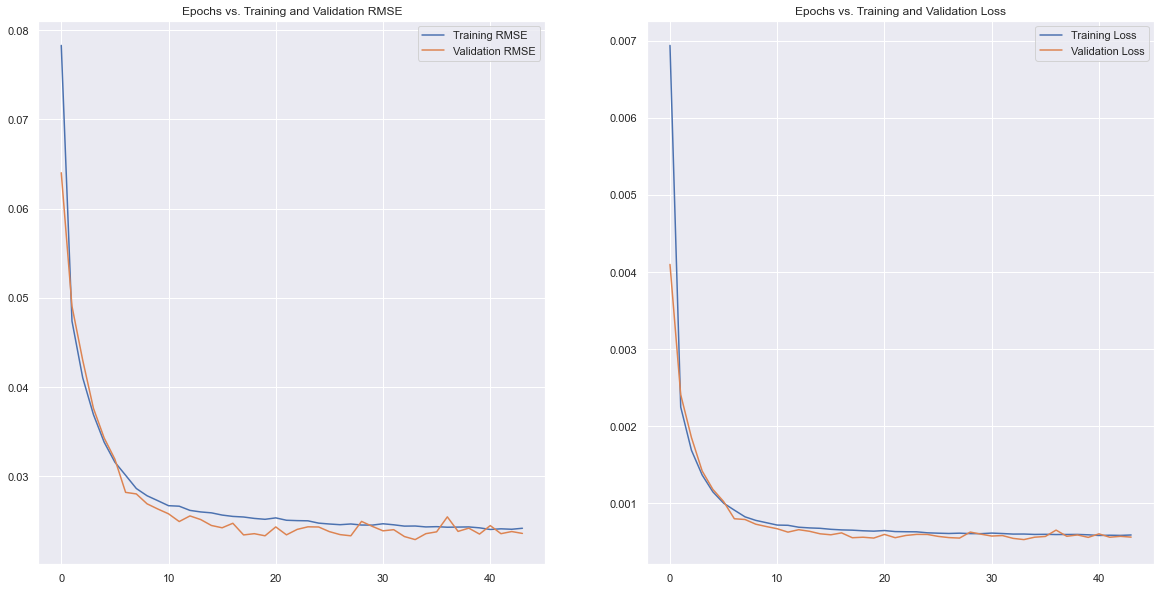

In [79]:
plot_rmse_with_losses(history)

RMSE de la prediccion del precio de la electricidad para la siguiente hora: 2.137
MAE de la prediccion del precio de la electricidad: 1.5913
Metrica U2 de la prediccion, mide la calidad de las predicciones: 0.6726


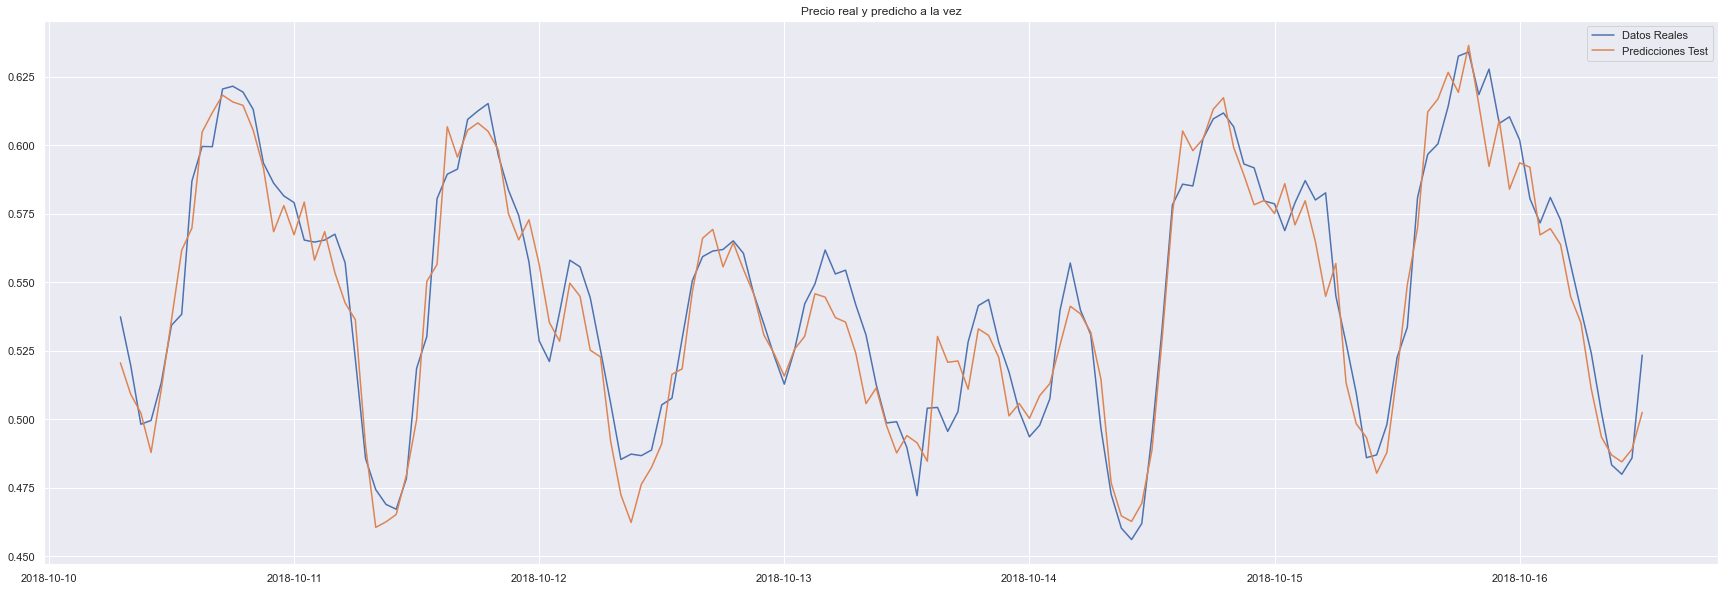

In [131]:
horas = 150
ind = df_final.index[33057+23:35064]
forecast = forecasts_metrics(check)
graf_precios(horas, ind)

### *1.2 LSTM*

In [76]:
# Red Neuronal Recurrente (LSTM = redes de memoria larga-corto plazo)
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, 
         return_sequences = True),
    Flatten(),
    Dense(70, activation = "relu"),
    Dropout(0.1),
    Dense(1)
])

check = "multivariate_lstm.h5"
opt = 6e-3
iteracciones = 100

history = establecer_check_opt_model(check, opt, multivariate_lstm, iteracciones)

Epoch 1/100
845/845 [==============================] - 11s 12ms/step - loss: 0.0234 - root_mean_squared_error: 0.1431 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 2/100
845/845 [==============================] - 9s 11ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 3/100
845/845 [==============================] - 10s 11ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 4/100
845/845 [==============================] - 9s 11ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 5/100
845/845 [==============================] - 10s 12ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 6/100
845/845 [==============================] - 10s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_los

845/845 [==============================] - 10s 12ms/step - loss: 6.7351e-04 - root_mean_squared_error: 0.0260 - val_loss: 6.4153e-04 - val_root_mean_squared_error: 0.0253
Epoch 47/100
845/845 [==============================] - 10s 12ms/step - loss: 7.0431e-04 - root_mean_squared_error: 0.0265 - val_loss: 6.0912e-04 - val_root_mean_squared_error: 0.0247
Epoch 48/100
845/845 [==============================] - 10s 12ms/step - loss: 6.8009e-04 - root_mean_squared_error: 0.0261 - val_loss: 6.1696e-04 - val_root_mean_squared_error: 0.0248
Epoch 49/100
845/845 [==============================] - 10s 12ms/step - loss: 6.9853e-04 - root_mean_squared_error: 0.0264 - val_loss: 5.8058e-04 - val_root_mean_squared_error: 0.0241
Epoch 50/100
845/845 [==============================] - 10s 12ms/step - loss: 6.7287e-04 - root_mean_squared_error: 0.0259 - val_loss: 7.2454e-04 - val_root_mean_squared_error: 0.0269
Epoch 51/100
845/845 [==============================] - 10s 12ms/step - loss: 6.6663e-04 - ro

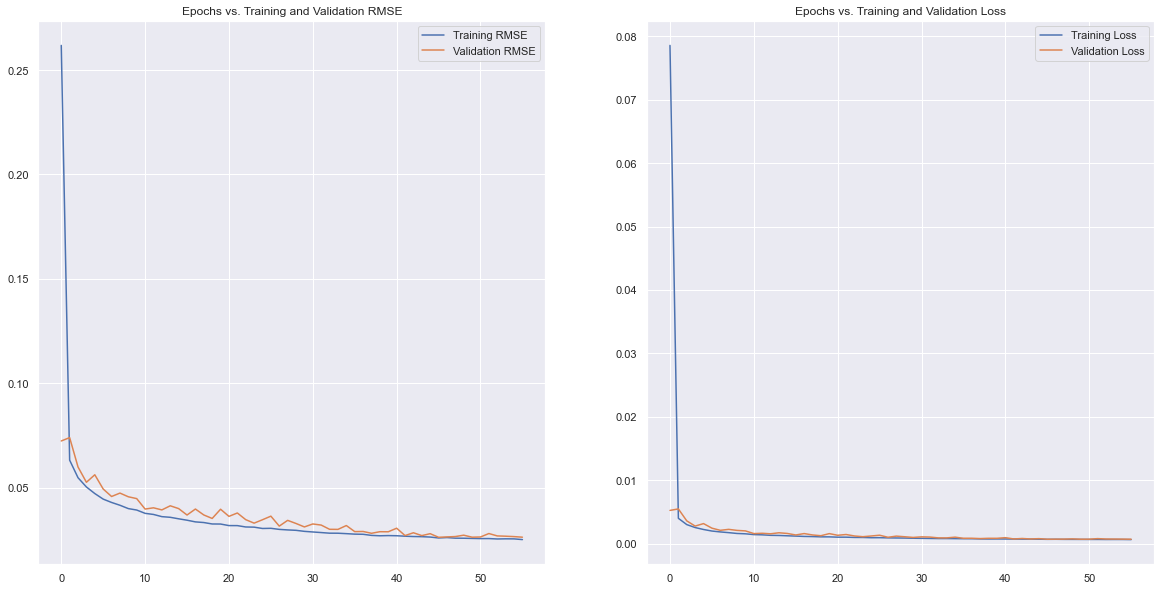

In [89]:
plot_rmse_with_losses(history)

RMSE de la prediccion del precio de la electricidad para la siguiente hora: 2.2154
MAE de la prediccion del precio de la electricidad: 1.6845
Metrica U2 de la prediccion, mide la calidad de las predicciones: 0.698


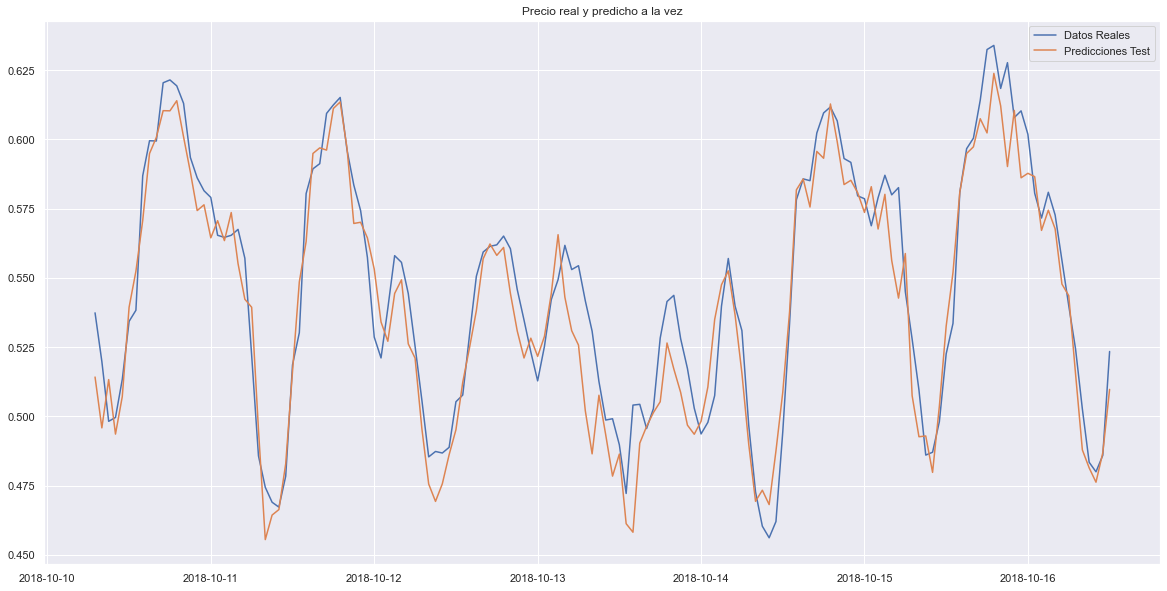

In [77]:
horas = 150
ind = df_final.index[33057+23:35064]
forecast = forecasts_metrics(check)
graf_precios(horas, ind)

### *1.3 Stacked LSTM*

In [60]:
# Comprende varias etiquetas LSTM - agrega complejidad al modelo
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, 
         return_sequences = True),
    LSTM(50, return_sequences = True),
    Flatten(),
    Dense(60, activation = "relu"),
    Dropout(0.1),
    Dense(1)
])

check = "multivariate_stacked_lstm.h5"
opt = 3e-3
iteracciones = 120

history = establecer_check_opt_model(check, opt, multivariate_stacked_lstm, iteracciones)

Epoch 1/120
845/845 [==============================] - 17s 17ms/step - loss: 0.0060 - root_mean_squared_error: 0.0727 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 2/120
845/845 [==============================] - 15s 18ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 3/120
845/845 [==============================] - 14s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 4/120
845/845 [==============================] - 15s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 5/120
845/845 [==============================] - 15s 18ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 6/120
845/845 [==============================] - 17s 20ms/step - loss: 9.5288e-04 - root_mean_squared_error: 0.0309 - v

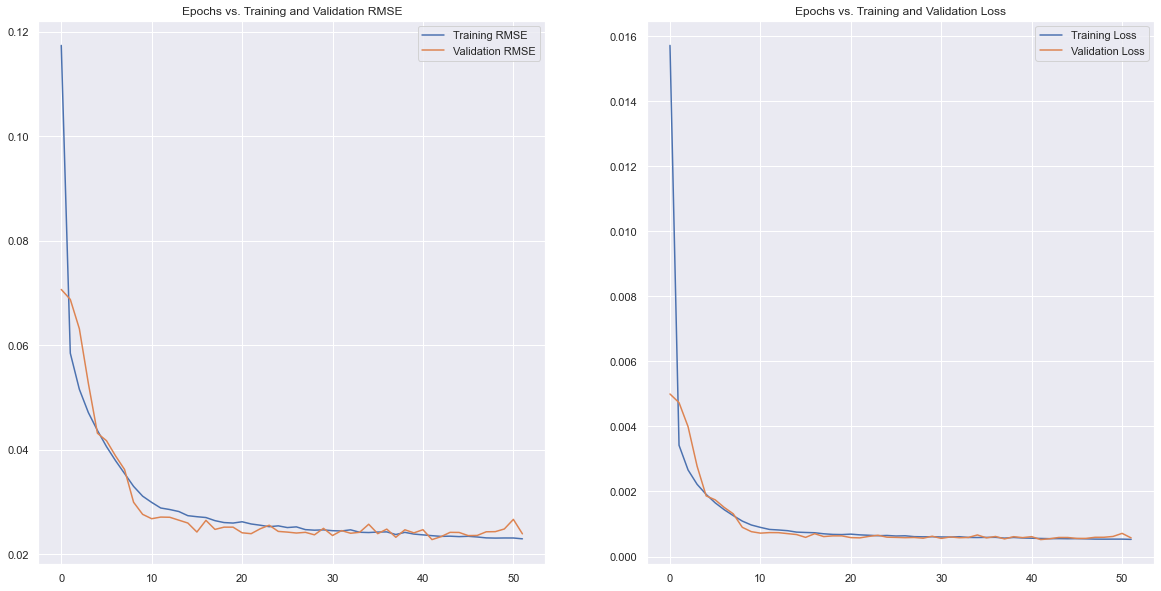

In [92]:
plot_rmse_with_losses(history)

RMSE de la prediccion del precio de la electricidad para la siguiente hora: 2.2092
MAE de la prediccion del precio de la electricidad: 1.6898
Metrica U2 de la prediccion, mide la calidad de las predicciones: 0.6959


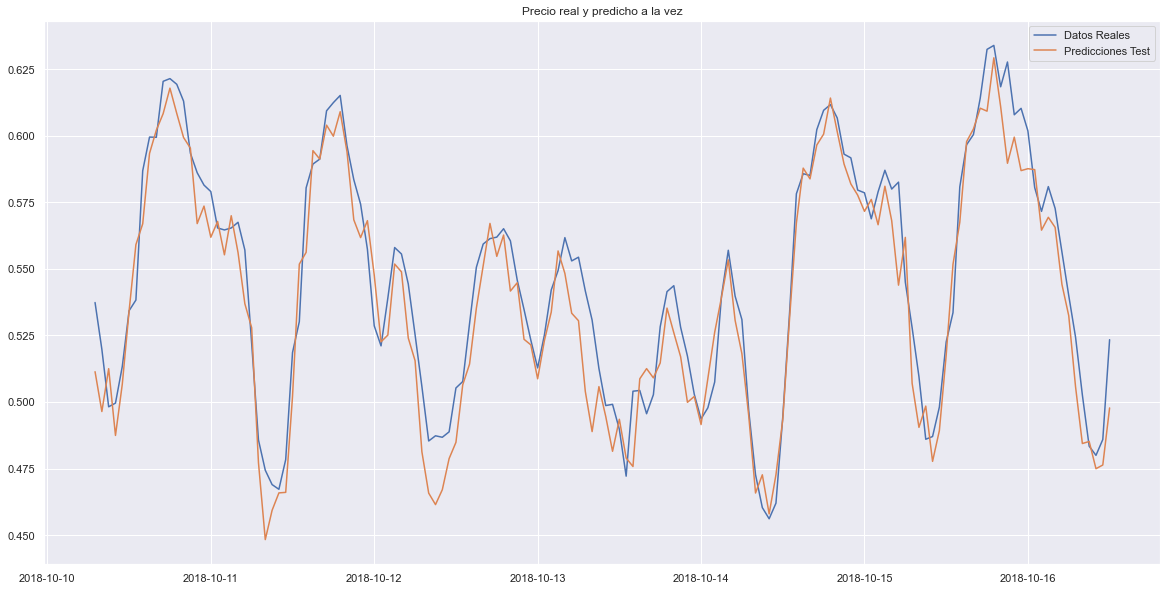

In [61]:
horas = 150
ind = df_final.index[33057+23:35064]
forecast = forecasts_metrics(check)
graf_precios(horas, ind)

### *1.4 CNN - LSTM*

In [67]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters = 36, kernel_size = 2,
           strides = 1, padding = "causal",
           activation = "relu", 
           input_shape = input_shape),
    LSTM(36, return_sequences = True),
    Flatten(),
    Dense(20, activation = "relu"),
    Dense(1)
])

check = "multivariate_cnn_lstm.h5"
opt = 4e-3
iteracciones = 100

history = establecer_check_opt_model(check, opt, multivariate_cnn_lstm, iteracciones)

Epoch 1/100
845/845 [==============================] - 7s 7ms/step - loss: 0.0036 - root_mean_squared_error: 0.0567 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 2/100
845/845 [==============================] - 6s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 3/100
845/845 [==============================] - 5s 6ms/step - loss: 9.6834e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 4/100
845/845 [==============================] - 6s 7ms/step - loss: 7.7855e-04 - root_mean_squared_error: 0.0279 - val_loss: 7.2682e-04 - val_root_mean_squared_error: 0.0270
Epoch 5/100
845/845 [==============================] - 6s 7ms/step - loss: 6.1692e-04 - root_mean_squared_error: 0.0248 - val_loss: 8.4442e-04 - val_root_mean_squared_error: 0.0291
Epoch 6/100
845/845 [==============================] - 6s 7ms/step - loss: 5.8677e-04 - root_mean_squared_error: 0.

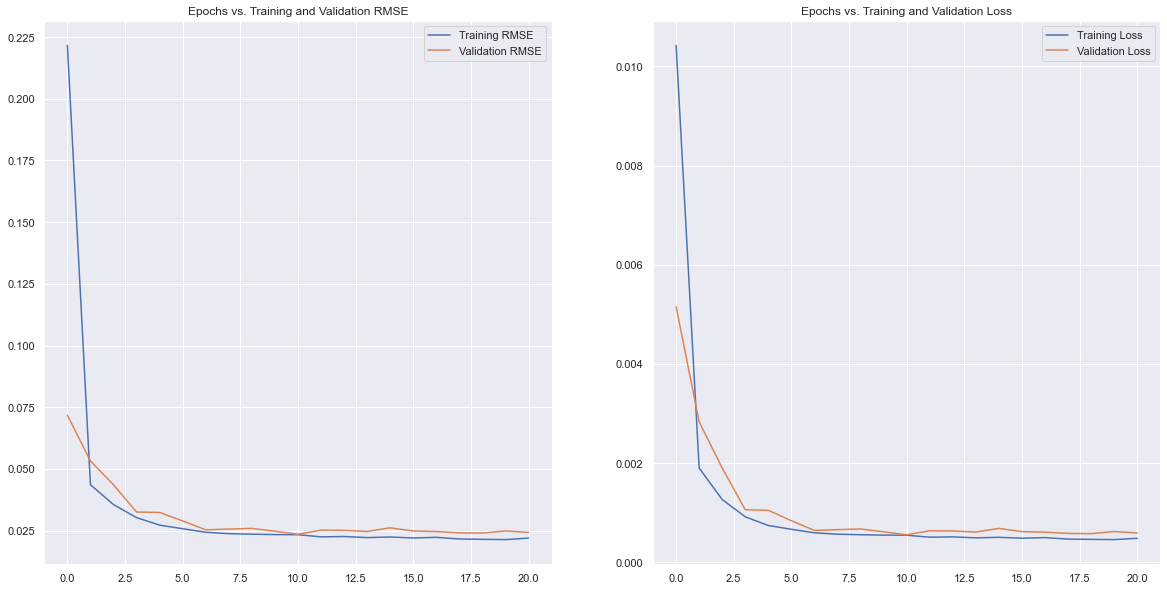

In [96]:
plot_rmse_with_losses(history)

RMSE de la prediccion del precio de la electricidad para la siguiente hora: 2.2088
MAE de la prediccion del precio de la electricidad: 1.6531
Metrica U2 de la prediccion, mide la calidad de las predicciones: 0.6977


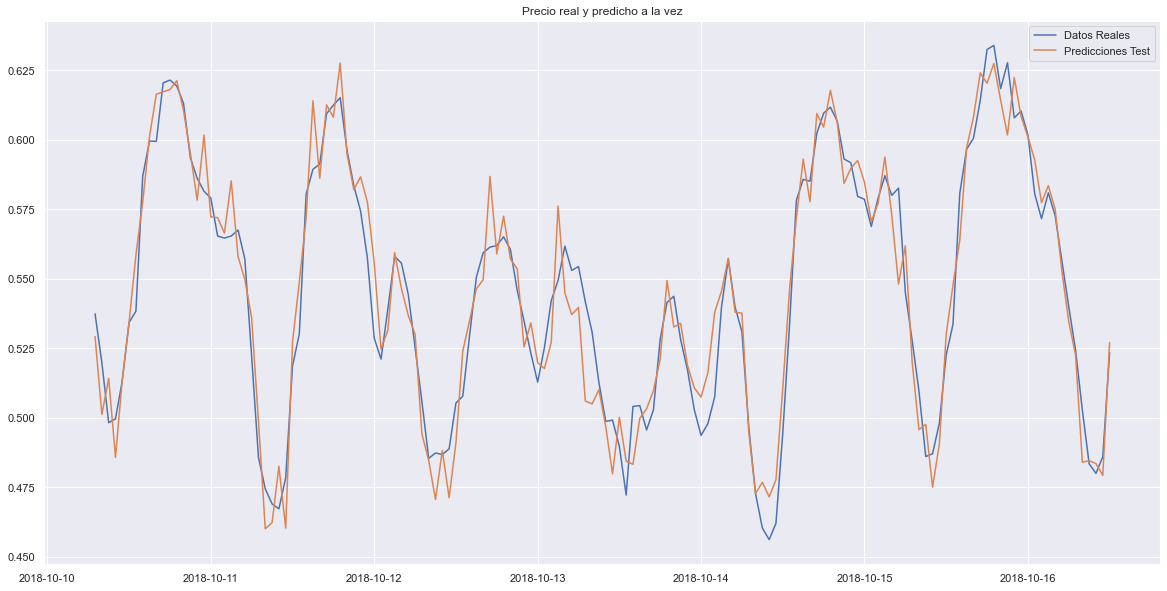

In [68]:
horas = 150
# ind = df_final.index[31057+23:35064] - Julio 2018
ind = df_final.index[33057+23:35064] # - Octubre 2018
forecast = forecasts_metrics(check)
graf_precios(horas, ind)

### *1.5 CNN*

In [119]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters = 36, kernel_size = 2,
           strides = 1, padding = "causal",
           activation = "relu", 
           input_shape = input_shape),
    Flatten(),
    Dense(36, activation = "relu"),
    Dense(1)
])

check = "multivariate_cnn.h5"
opt = 6e-3
iteracciones = 100

history = establecer_check_opt_model(check, opt, multivariate_cnn, iteracciones)

Epoch 1/100
845/845 [==============================] - 1s 1ms/step - loss: 0.0187 - root_mean_squared_error: 0.1278 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 2/100
845/845 [==============================] - 1s 1ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 3/100
845/845 [==============================] - 1s 1ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 4/100
845/845 [==============================] - 1s 1ms/step - loss: 9.0420e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 5/100
845/845 [==============================] - 1s 1ms/step - loss: 8.1542e-04 - root_mean_squared_error: 0.0286 - val_loss: 8.9911e-04 - val_root_mean_squared_error: 0.0300
Epoch 6/100
845/845 [==============================] - 4s 5ms/step - loss: 7.5152e-04 - root_mean_squared_error: 0.0274 - v

845/845 [==============================] - 3s 3ms/step - loss: 4.6584e-04 - root_mean_squared_error: 0.0216 - val_loss: 5.4408e-04 - val_root_mean_squared_error: 0.0233
Epoch 47/100
845/845 [==============================] - 3s 4ms/step - loss: 4.7328e-04 - root_mean_squared_error: 0.0218 - val_loss: 5.6940e-04 - val_root_mean_squared_error: 0.0239
Epoch 48/100
845/845 [==============================] - 3s 3ms/step - loss: 4.5915e-04 - root_mean_squared_error: 0.0214 - val_loss: 5.3821e-04 - val_root_mean_squared_error: 0.0232
Epoch 49/100
845/845 [==============================] - 3s 3ms/step - loss: 4.5945e-04 - root_mean_squared_error: 0.0214 - val_loss: 5.4289e-04 - val_root_mean_squared_error: 0.0233
Epoch 50/100
845/845 [==============================] - 3s 3ms/step - loss: 4.5477e-04 - root_mean_squared_error: 0.0213 - val_loss: 5.3391e-04 - val_root_mean_squared_error: 0.0231
Epoch 51/100
845/845 [==============================] - 3s 4ms/step - loss: 4.6471e-04 - root_mean_squa

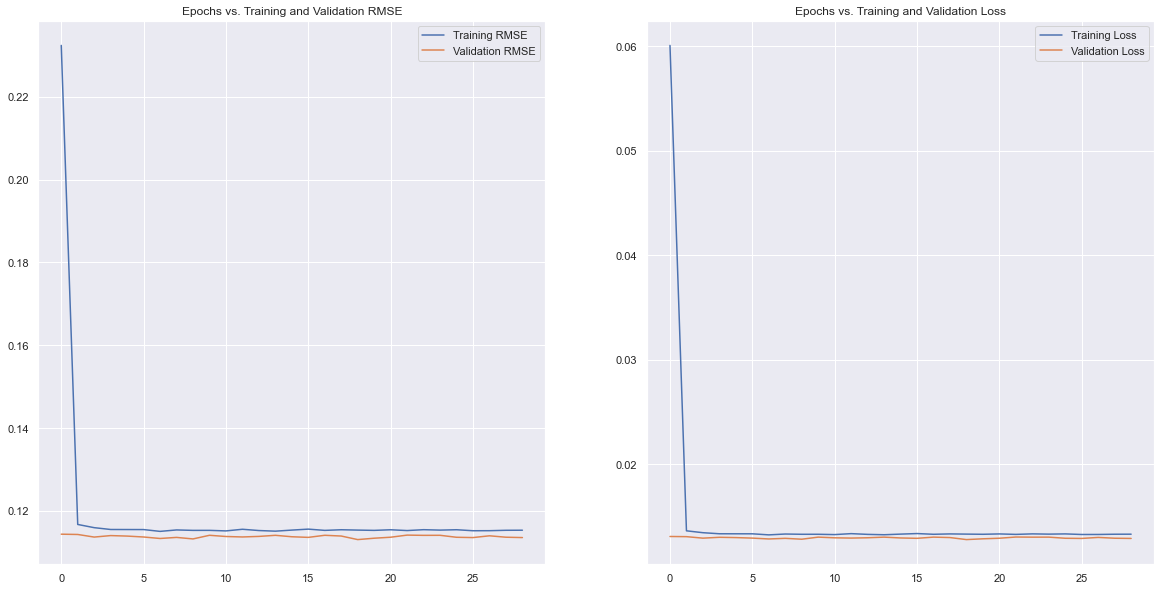

In [102]:
plot_rmse_with_losses(history)

RMSE de la prediccion del precio de la electricidad para la siguiente hora: 2.1481
MAE de la prediccion del precio de la electricidad: 1.5965
Metrica U2 de la prediccion, mide la calidad de las predicciones: 0.6732


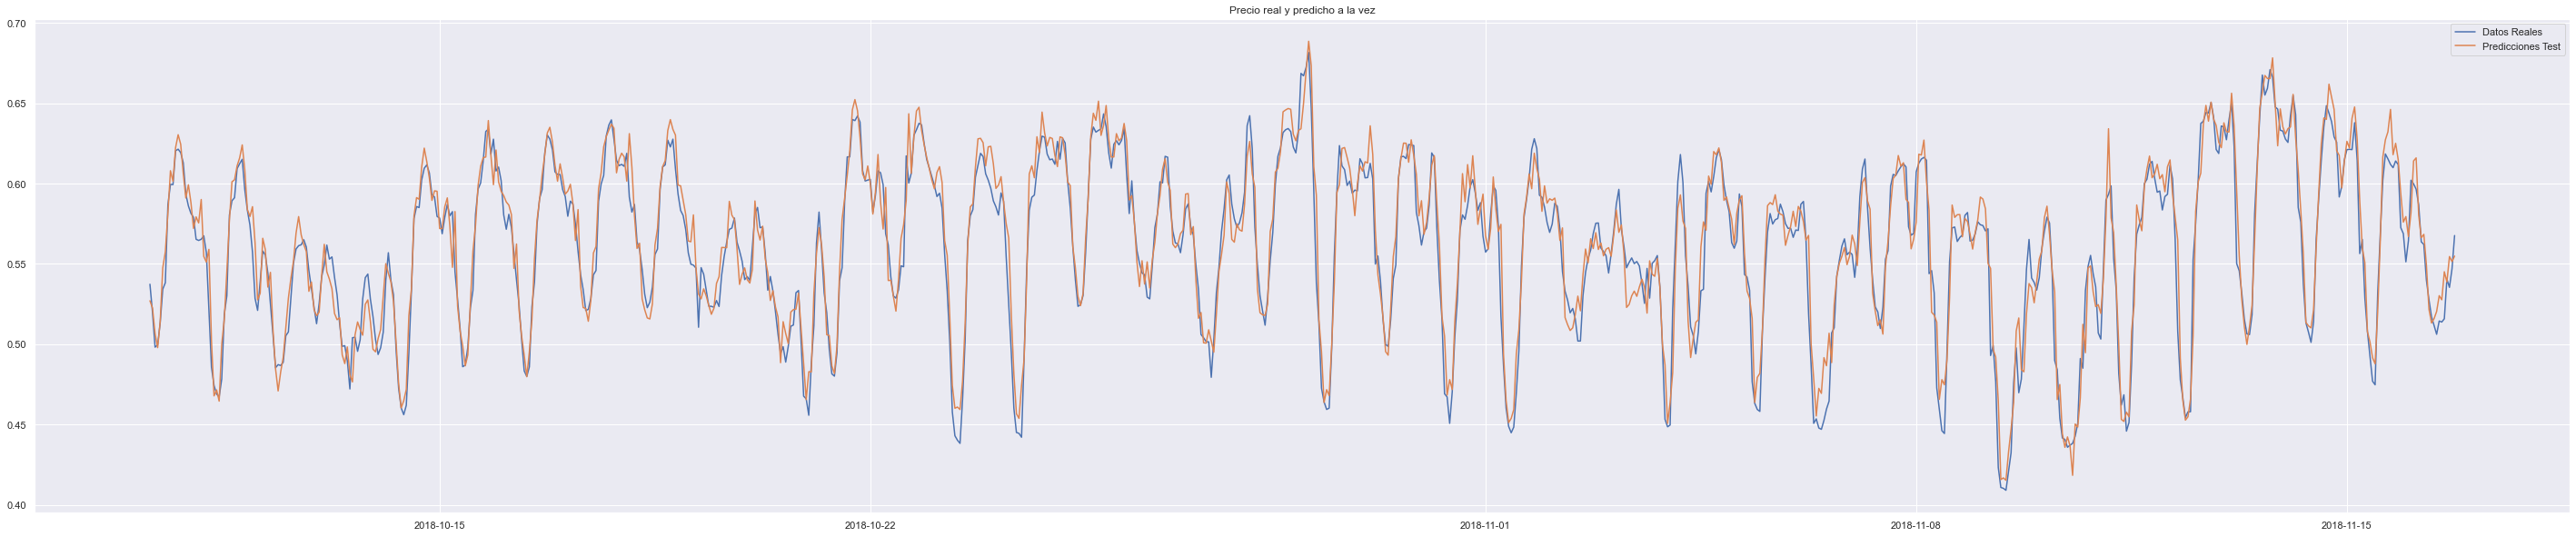

In [120]:
horas = 900
ind = df_final.index[33057+23:35064]
forecast = forecasts_metrics(check)
graf_precios(horas, ind)

### *1.6 Encoder - Decoder*

In [132]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(80, activation = "relu", input_shape = input_shape),
    RepeatVector(chunks),
    LSTM(40, activation = "relu", return_sequences=True),
    TimeDistributed(Dense(50, activation = "relu")),
    Flatten(),
    Dense(20, activation = "relu"),
    Dense(1)
])

# Estas redes neuronales, comp. princip. no lineales - transforma con pocas variables- capturando toda la inf.

check = "encoder_decoder.h5"
opt = 1e-3
iteracciones = 50

history = establecer_check_opt_model(check, opt, encoder_decoder, iteracciones)

Epoch 1/50
845/845 [==============================] - 14s 15ms/step - loss: 0.0045 - root_mean_squared_error: 0.0634 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 2/50
845/845 [==============================] - 13s 15ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 3/50
845/845 [==============================] - 14s 16ms/step - loss: 8.9835e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 4/50
845/845 [==============================] - 14s 16ms/step - loss: 7.9986e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 5/50
845/845 [==============================] - 14s 16ms/step - loss: 6.6967e-04 - root_mean_squared_error: 0.0259 - val_loss: 7.7213e-04 - val_root_mean_squared_error: 0.0278
Epoch 6/50
845/845 [==============================] - 14s 17ms/step - loss: 6.1982e-04 - root_mean_squared_error: 

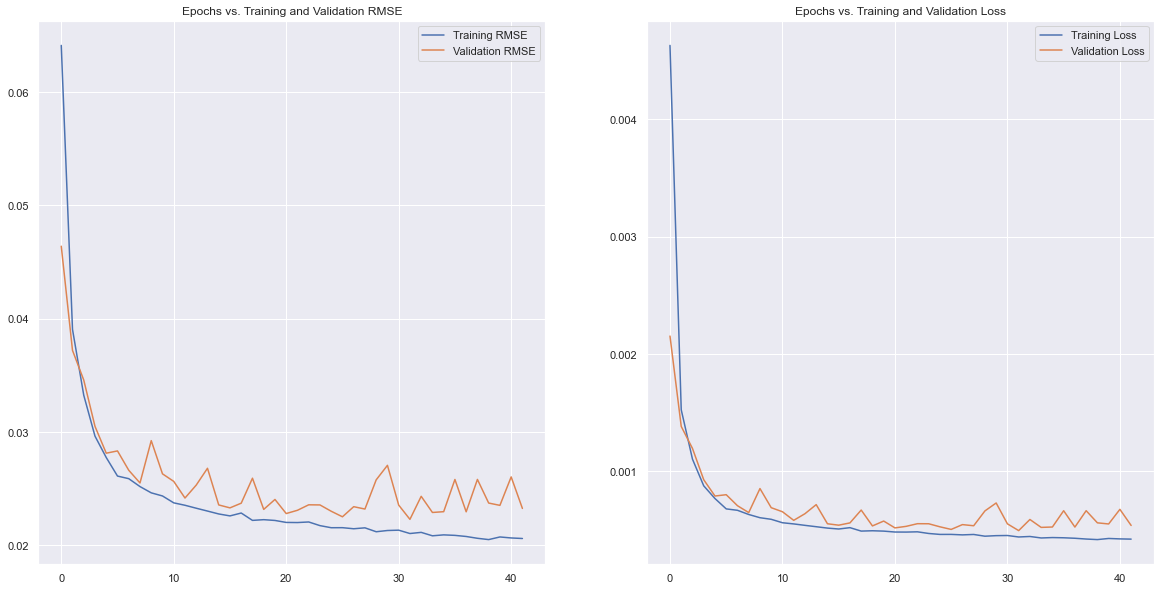

In [83]:
plot_rmse_with_losses(history)

RMSE de la prediccion del precio de la electricidad para la siguiente hora: 2.2981
MAE de la prediccion del precio de la electricidad: 1.7449
Metrica U2 de la prediccion, mide la calidad de las predicciones: 0.725


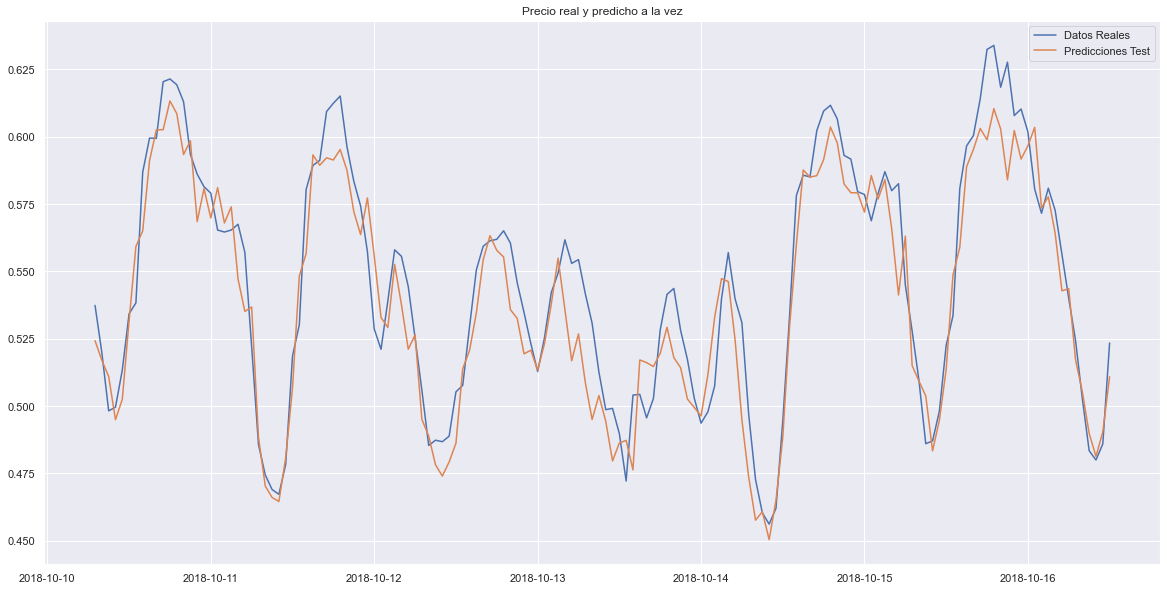

In [133]:
horas = 150
ind = df_final.index[31057+23:35064]
forecast = forecasts_metrics(check)
graf_precios(horas, ind)

## 2. Modelos Autoregresivos

### *2.1 ARIMA*

In [259]:
# Conjunto de entrenamiento = 27048 
precio = df_final["price actual"].diff().iloc[1:].values
X = precio[:27048]
model = ARIMA(X)
result = model.fit()

print("Valor del criterio Hannan-Quinn : {}".format(round(result.hqic, 4)))

print("RMSE : {}".format(round(sqrt(result.mse), 4)))

print("MAE : {}".format(round(result.mae, 4)))

print(result.summary())

result.plot_diagnostics()

Valor del criterio Hannan-Quinn : 148722.8812
RMSE : 3.7815
MAE : 2.6197
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                27048
Model:                          ARIMA   Log Likelihood              -74356.795
Date:                Sat, 11 Dec 2021   AIC                         148717.590
Time:                        18:40:11   BIC                         148734.000
Sample:                             0   HQIC                        148722.881
                              - 27048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -6.86e-05      0.023     -0.003      0.998      -0.046       0.046
sigma2        14.3000      0.075    191.627      0.000    

### *2.2 SARIMA*

Valor del criterio Hannan-Quinn : 140951.3039
RMSE : 3.2755
MAE : 2.2568
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                27048
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -70471.006
Date:                Sat, 11 Dec 2021   AIC                         140946.012
Time:                        18:41:29   BIC                         140962.423
Sample:                             0   HQIC                        140951.304
                              - 27048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4997      0.004    127.687      0.000       0.492       0.507
sigma2        10.7289      0.050    214.456      0.000    

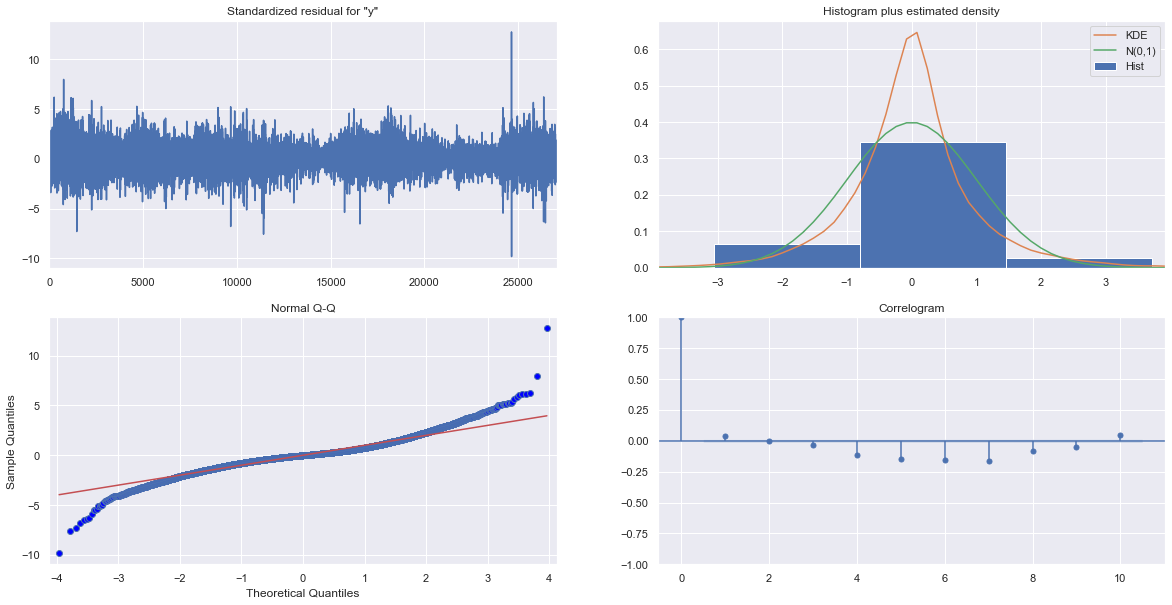

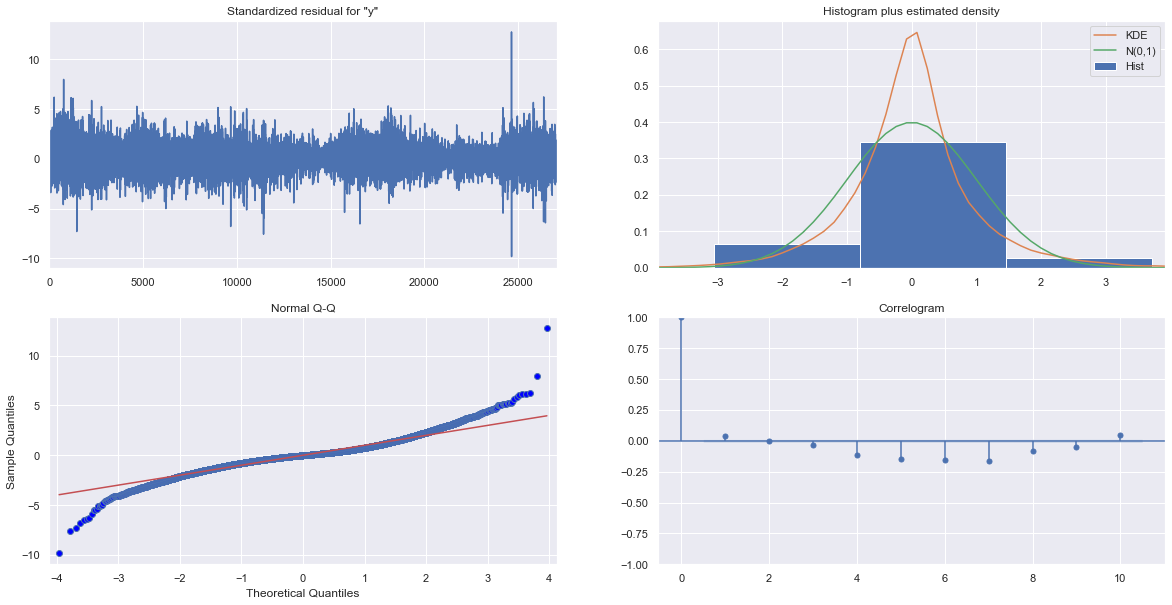

In [261]:
# Conjunto de entrenamiento = 27048 
precio = df_final["price actual"].diff().iloc[1:].values
X = precio[:27048]
model = sm.tsa.SARIMAX(X)
result = model.fit()

print("Valor del criterio Hannan-Quinn : {}".format(round(result.hqic, 4)))

print("RMSE : {}".format(round(sqrt(result.mse), 4)))

print("MAE : {}".format(round(result.mae, 4)))

print(result.summary())

result.plot_diagnostics()